### Questions to answer:
1. What do the timing distributions look like?
2. How does AoS compare to SoA?
3. How does tuple size affect timing?
4. How does complexity affect timing?
5. How does access pattern affect timing?

## 1. What do the timing distributions look like? Do we see linearity through container size and number of iterations?

### Getting set up

First, we must load the dataframe. Additionally, we import our dataframe plotting library, aliased here as 'D'.

In [1]:
%matplotlib inline
import pandas as pd
df = pd.read_pickle('unpack_benchmark.dataframe')
import df_plot as D
import numpy as np
import matplotlib.pyplot as plt

First, we want to look at a timing distribution. To do this, we define a filter dictionary to constrain our dataframe:

In [2]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'container_size': 32768,
    'iterations': 32768
}

Before we actually filter the dataset, we can take a look at the type of data which will be returned.

In [3]:
import df_plot as D
import pprint
pp = pprint.PrettyPrinter(indent=2)
unique = D.unique_set(df)
pp.pprint(D.get_selection_type(unique, filter_dict))

Querying with this filter will yield data with these dimensions unspecified:

{ 'benchmarking_tool': array(['chrono_benchmark'], dtype=object),
  'compiler': array(['g++-7.1'], dtype=object),
  'container': array(['vector'], dtype=object),
  'optimization': array(['O3'], dtype=object),
  'run_id': array(['1'], dtype=object),
  'system_memory': array(['64GB'], dtype=object),
  'system_os': array(['Red Hat Enterprise Linux Server 6.9 (Santiago)'], dtype=object),
  'system_processor': array(['Intel(R) Xeon(R) CPU E5-2680 @ 2.70GHz'], dtype=object)}


This looks ok. All of the free dimensions have array sizes of 1. This means we should get 1 dimensional timing data querying with this filter dict.

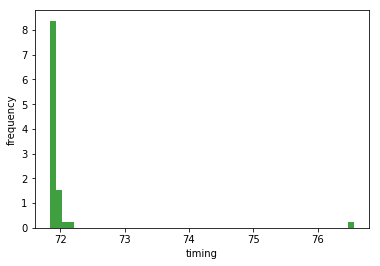

In [4]:
selection = D.filter_df(filter_dict, df)
D.histogram(selection, 'timing')

### Testing for linearity through iterations (single case)

x: [      1      32    1024   32768 1048576]
y: [  9.00243151e-07   2.41962567e-07   5.23910160e-07   3.83405791e-07
   3.46534421e-07]


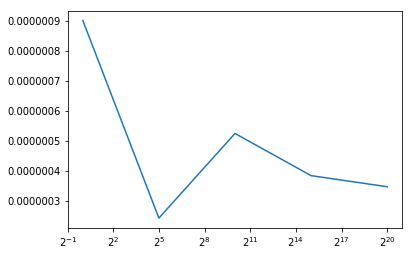

In [5]:
filter_dict = {
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'aos',
    'container_size': 131072
}
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'iterations', 'timing', sortx=True)
x = np.asarray(x)
y = np.asarray(y) / (x * 1024)

print('x: ' + str(x))
print('y: ' + str(y))

plt.semilogx(x,y,basex=2)

# D.linearity_test(x, y, show_output=True)

This shows how linearity testing will work for each configuration. We'll now go through to verify that every configuration displays the same type of linearity.

### Testing for linearity through iterations (all configurations)

In [6]:
# this takes > an hour
# D.linearity_test_all(unique, df, test_dimension='iterations')

##### What this means...

Because all of these parameter configurations are showing an essentially perfect linear fit, we can proceed with analysis using only the highest iteration data points. These high iteration configurations will have the least noise and we won't lose any information from the lower iteration configurations.

### Testing for linearity through container size (single configuration)

Now that we've established we can look at solely the highest iteration data points, let's take a look at container size and verify we see the same type of linearity there.

TODO: Find the 10 least linear, and plot in both linear and log scale

x: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]
y: [0.07234747, 0.14149547, 0.27709749, 0.56644583, 1.1007181, 2.1939662, 4.4165416, 8.7795639, 17.571589, 35.182793, 70.267639, 141.51245, 283.14798, 569.94684, 1183.4451, 2449.3101]
R2 score: 0.99956011
An R2 of 1 is a perfect fit. Range: (-infty, 1]
[ -5.92746475e+00  -5.85324549e+00  -5.70480696e+00  -5.40792990e+00
  -4.81417577e+00  -3.62666753e+00  -1.25165105e+00   3.49838191e+00
   1.29984478e+01   3.19985797e+01   6.99988434e+01   1.45999371e+02
   2.98000426e+02   6.02002536e+02   1.21000676e+03   2.42601519e+03]


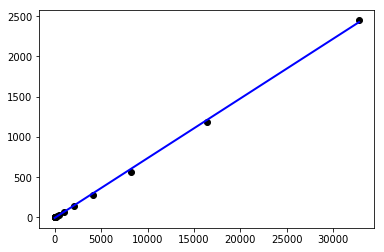

0.99956011129361877

In [7]:
filter_dict = {
    'access_pattern': 'independent',
    'complexity': 'complex',
    'column': 'nocolumn',
    'type': 'std::tuple<double, double, double, double>',
    'orientation': 'soa',
    'iterations': 1048576
}
selection = D.filter_df(filter_dict, df)
x, y = D.xy(selection, 'container_size', 'timing', sortx=True)
print('x: ' + str(x))
print('y: ' + str(y))
D.linearity_test(x, y, show_output=True)

### Testing for linearity through container size (all iterations)

In [8]:
# this takes > an hour
# D.linearity_test_all(unique, df, test_dimension='container_size')

##### What this means...

We've now verified that we can do further analysis considering only the highest container size data points. 

## 2. How does AoS compare to SoA?

For this experiment, we'll use iterations per second as a sort of timing normalizer so we can better compare varying parameter configurations.

MAYBE: vary the container size as well in same plot
TODO: X-axis log scale

#### How they're affected by tuple size

{'soa': {'x': [1, 2, 4, 8], 'y': [0.0509586, 0.085127346, 0.065179855, 0.065145604]}, 'aos': {'x': [1, 2, 4, 8], 'y': [0.050709225, 0.074053936, 0.059565369, 0.083438076]}}


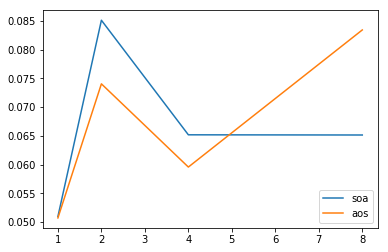

In [9]:
# need this to get the experiment's filter set
must_haves = {
    'container_size': 1024,
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768,
}
let_vary = ['orientation']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['int'], [1,2,4,8])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df) 
selection = D.numeric_types(selection)
multi_xy = D.multi_xy(selection, 'type', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_line_plot(multi_xy)

#### How they're affected by access pattern

TODO: How can we show results for multiple type "bases"

{'aos': {'x': ['combined', 'independent', 'single'], 'y': [10.228698, 7.570085, 7.2594314]}, 'soa': {'x': ['combined', 'independent', 'single'], 'y': [7.7701082, 11.992025, 2.6044223]}}


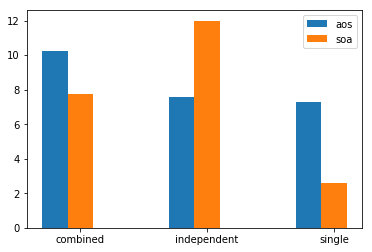

In [10]:
must_haves = {
    'container_size': 1048576,
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 1024,
    'type': 'std::tuple<double, double, double, double>'
}
let_vary = ['orientation', 'access_pattern']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
selection = D.multi_filter_df(filter_dicts, df)
multi_xy = D.multi_xy(selection, 'access_pattern', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_bar(multi_xy)

#### More information in single graph

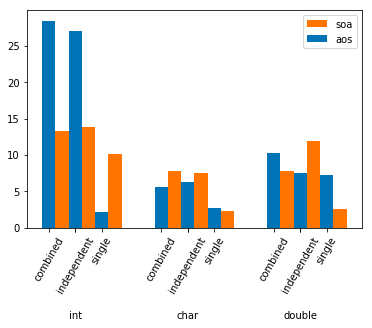

In [11]:
must_haves = {
    'container_size': 1048576,
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 1024,
}
let_vary = ['orientation', 'access_pattern']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['char', 'int', 'double'], [4])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df)
selection = D.add_type_bases(selection)
m2_xy = D.m2_xy(selection, 'access_pattern', 'timing', 'orientation', \
                            'type_base', sortx=True)
D.m2_bar(m2_xy, color_ary=['#0074b7', '#ff7500'], label_rotation=60, label_shift=-.35)

#### How they're affected by complexity

{'soa': {'x': ['complex', 'simple'], 'y': [593.12738, 78.19384]}, 'aos': {'x': ['complex', 'simple'], 'y': [602.9082, 222.388]}}


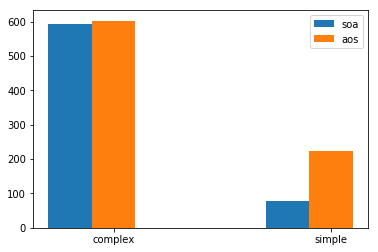

In [12]:
must_haves = {
    'access_pattern': 'single',
    'container_size': 1048576,
    'column': 'nocolumn',
    'iterations': 32768,
    'type': 'std::tuple<double, double, double, double>'
}
let_vary = ['orientation', 'complexity']
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
selection = D.multi_filter_df(filter_dicts, df)
multi_xy = D.multi_xy(selection, 'complexity', 'timing', 'orientation', sortx=True)
print(multi_xy)
D.multi_bar(multi_xy)

### 3. How does tuple size affect timing?

Here we can see what I think are effects from cache line sizes

{'int': {'x': [1, 2, 4, 8], 'y': [52.765556, 88.750084, 67.265747, 68.709785]}, 'char': {'x': [1, 4], 'y': [49.271606, 75.392082]}, 'double': {'x': [1, 2, 4, 8], 'y': [71.850609, 51.37072, 78.19384, 44.674389]}}


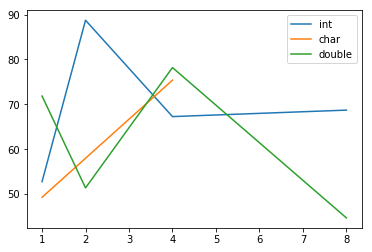

In [13]:
must_haves = {
    'container_size': 1048576,
    'access_pattern': 'single',
    'complexity': 'simple',
    'column': 'nocolumn',
    'iterations': 32768,
    'orientation': 'soa'
}
let_vary = []
filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
allowed_types = D.make_tuple_types(['char', 'int', 'double'], [1,2,4,8])
filter_dicts = D.constrain_types(filter_dicts, allowed_types)
selection = D.multi_filter_df(filter_dicts, df)
selection = D.add_type_bases(selection)
selection = D.numeric_types(selection)
multi_xy = D.multi_xy(selection, 'type', 'timing', 'type_base', sortx=True)
print(multi_xy)
D.multi_line_plot(multi_xy)

### Results Section 1

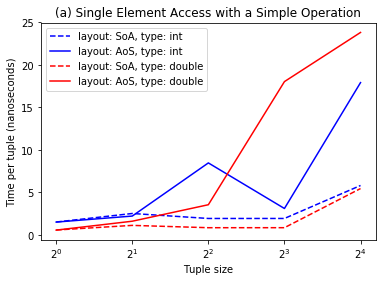

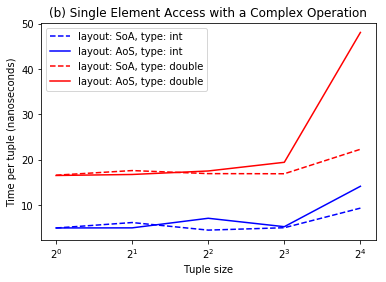

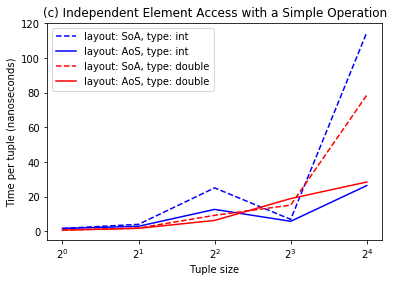

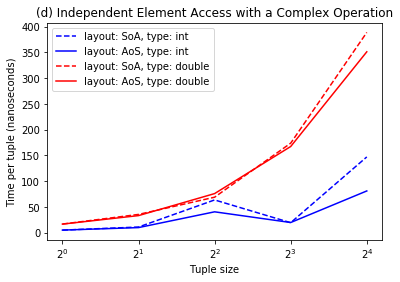

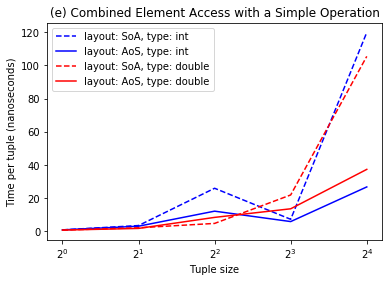

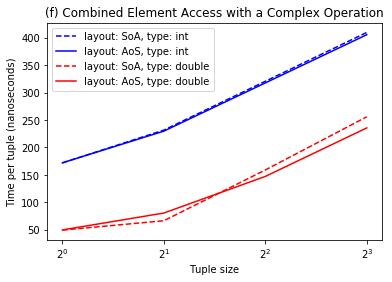

In [22]:
ap = ['single', 'independent', 'combined']
complexity = ['simple', 'complex']
lbls = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
lbl_idx = 0
def to_pretty(o):
    if o == 'aos':
        return 'AoS'
    else:
        return 'SoA'

for _ap in ap:
    for _cp in complexity:
        must_haves = {
            'container_size': 262144,
            'access_pattern': _ap,
            'complexity': _cp,
            'column': 'nocolumn',
            'iterations': 32768,
        }
        filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
        allowed_types = D.make_tuple_types(['int', 'double'], [1,2,4,8,16])
        filter_dicts = D.constrain_types(filter_dicts, allowed_types)
        selection = D.multi_filter_df(filter_dicts, df)
        selection = D.add_type_bases(selection)
        selection = D.numeric_types(selection)
        selection['timing'] = selection['timing'].apply(lambda l: np.mean(l))

        d = dict()

        plt.figure()
        legend = list()
        for type in selection['type_base'].unique():
            d[type] = dict()
            for orientation in selection['orientation'].unique():
                d[type][orientation] = dict()
                tmp = selection[(selection['orientation'] == orientation) & (selection['type_base'] == type)].sort_values('type')
                x = tmp['type'].values
                y = tmp['timing'].values * 1e9
                y /= tmp['container_size']
                y /= tmp['iterations']
                x = list(x)
                y = list(y)
                if type == 'double':
                    line_style = 'r'
                else:
                    line_style = 'b'
                if orientation == 'soa':
                    line_style += '--'
                else:
                    line_style += '-'
                plt.plot(x, y, line_style)
                legend.append('layout: {j}, type: {i}'.format(i=type, j=to_pretty(orientation)))
        lbl = lbls[lbl_idx]
        lbl_idx += 1
        plt.title('{lbl} {i} Element Access with a {j} Operation'.format(lbl=lbl, i=_ap.capitalize(),j=_cp.capitalize()))
        plt.xlabel('Tuple size')
        plt.ylabel('Time per tuple (nanoseconds)')
        plt.gca().set_xscale("log", nonposx='clip', basex=2)
        plt.legend(legend, loc=0, prop={'size': 10})
        plt.savefig('{i}_{j}.png'.format(i=_cp,j=_ap))

### Results Section 2

,char,short int,int,long long int,unsigned long long int
"combined, simple, aos",1.64385,2.4947,2.43771,1.81256,2.35103
"combined, simple, soa",1.97112,1.97241,2.76552,2.02182,2.42579
"independent, complex, aos",2.90901,3.00501,3.66018,3.14494,3.02437
"independent, complex, soa",2.85735,2.96326,3.84865,3.09625,2.98303
"independent, simple, aos",1.74445,1.62546,2.41926,1.81721,1.8037
"independent, simple, soa",1.94624,1.94569,2.78257,1.97279,1.97581
"single, complex, aos",1.53796,1.61187,1.61245,1.75405,1.63955
"single, complex, soa",1.56822,1.62788,1.49215,1.76311,1.64659
"single, simple, aos",0.895942,1.02047,1.05325,1.05384,1.03095
"single, simple, soa column",0.705164,0.340525,0.422741,0.58386,0.552557


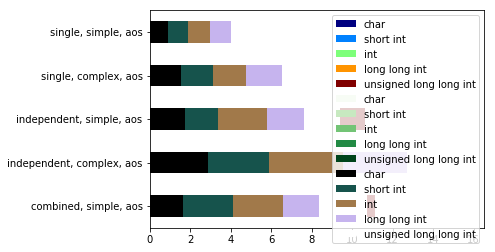

In [37]:
from math import log
ap = ['combined', 'independent', 'single']
complexity = ['complex', 'simple']
types = ['char', 'short int', 'int', 'long long int', 'unsigned long long int']
orientations = ['aos', 'soa']
column = ['column', 'nocolumn']

idxs = {'aos': [], 'soa': [], 'soac': []}

fig = plt.figure()
ax = fig.add_subplot(111)

for _ap in ap:
    for _cp in complexity:
        for o in orientations:
            for _col in column:
                if _ap == 'combined' and _cp == 'complex':
                    continue
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                
                if _col == 'column':
                    idxs['soac'].append(idx_str)
                elif o == 'soa':
                    idxs['soa'].append(idx_str)
                else:
                    idxs['aos'].append(idx_str)
dfs = dict()
dfs['aos'] = pd.DataFrame(columns=types, index=idxs['aos'])
dfs['soa'] = pd.DataFrame(columns=types, index=idxs['soa'])
dfs['soac'] = pd.DataFrame(columns=types, index=idxs['soac'])

for _ap in ap:
    for _cp in complexity:
        for _col in column:
            if _ap == 'combined' and _cp == 'complex':
                continue
            must_haves = {
                'container_size': 65536,
                'access_pattern': _ap,
                'complexity': _cp,
                'column': _col,
                'iterations': 32768
            }
                
            filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
            allowed_types = D.make_tuple_types(types, [4])
            filter_dicts = D.constrain_types(filter_dicts, allowed_types)
            selection = D.multi_filter_df(filter_dicts, df)
            selection = D.add_type_bases(selection)
            selection['timing'] = selection['timing'].apply(lambda l: np.mean(l) * 1e9)
            selection['timing'] /= selection['container_size']
            selection['timing'] /= selection['iterations']
            for o in ['aos', 'soa']:
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                o_sel = selection[selection['orientation'] == o]
                d = dict()
                for t in types:
                    d[t] = log(o_sel[o_sel['type_base'] == t].iloc[0]['timing'])
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                
                if _col == 'column':
                    dfs['soac'].loc[idx_str] = d
                elif o == 'soa':
                    dfs['soa'].loc[idx_str] = d
                else:
                    dfs['aos'].loc[idx_str] = d

dfs['soa'].plot.barh(stacked=True, ax=ax, colormap='jet')
dfs['soac'].plot.barh(stacked=True, ax=ax, colormap='Greens')
dfs['aos'].plot.barh(stacked=True, ax=ax, colormap='cubehelix')
fig = ax.get_figure()
fig.savefig('log_scale', bbox_inches='tight')
df2

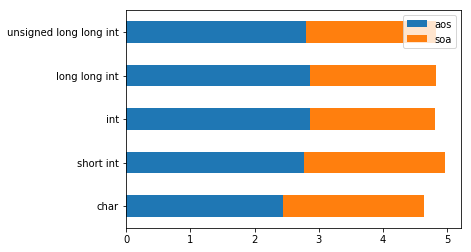

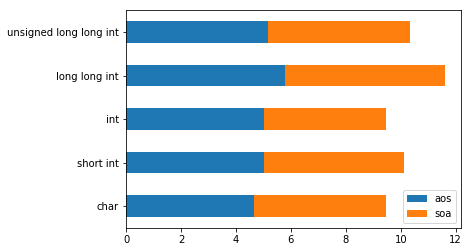

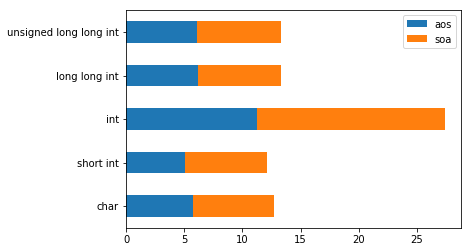

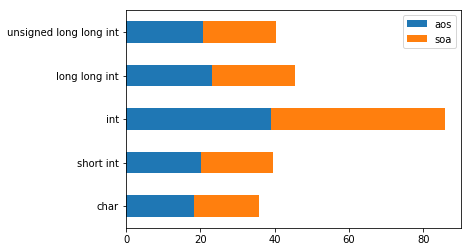

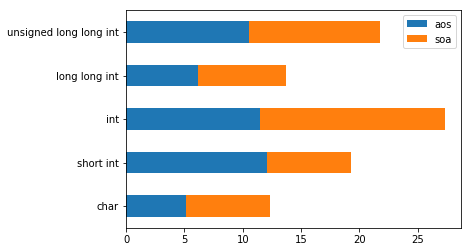

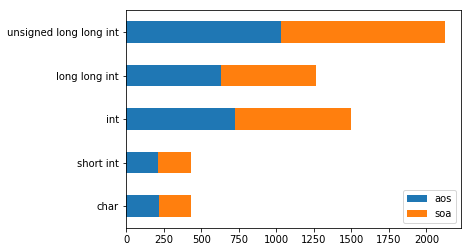

In [16]:
from math import log
ap = ['single', 'independent', 'combined']
complexity = ['simple', 'complex']
types = ['char', 'short int', 'int', 'long long int', 'unsigned long long int']
orientations = ['aos', 'soa']
idxs = list()

for _ap in ap:
    df2 = pd.DataFrame(columns=orientations, index=types)
    for _cp in complexity:
        must_haves = {
            'container_size': 65536,
            'access_pattern': _ap,
            'complexity': _cp,
            'column': 'nocolumn',
            'iterations': 32768
        }
        filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
        allowed_types = D.make_tuple_types(types, [4])
        filter_dicts = D.constrain_types(filter_dicts, allowed_types)
        selection = D.multi_filter_df(filter_dicts, df)
        selection = D.add_type_bases(selection)
        selection['timing'] = selection['timing'].apply(lambda l: np.mean(l) * 1e9)
        selection['timing'] /= selection['container_size']
        selection['timing'] /= selection['iterations']
        for t in types:
            t_sel = selection[selection['type_base'] == t]
            d = dict()
            for o in orientations:
                d[o] = t_sel[t_sel['orientation'] == o].iloc[0]['timing']
            df2.loc[t] = d
        ax = df2.plot.barh(stacked=True)    

['/', '/', '/', '/', '/', '.', '.', '.', '.', '.', '|', '|', '|', '|', '|', '/', '/', '/', '/', '/', '|', '|', '|', '|', '|', '/', '/', '/', '/', '/', '|', '|', '|', '|', '|', '/', '/', '/', '/', '/', '|', '|', '|', '|', '|', '/', '/', '/', '/', '/', '|', '|', '|', '|', '|', '/', '/', '/', '/', '/', '|', '|', '|', '|', '|']


,char,short int,int,long long int,unsigned long long int
"combined, simple, aos",1.64385,2.4947,2.43771,1.81256,2.35103
"combined, simple, soa",1.97112,1.97241,2.76552,2.02182,2.42579
"independent, complex, aos",2.90901,3.00501,3.66018,3.14494,3.02437
"independent, complex, soa",2.85735,2.96326,3.84865,3.09625,2.98303
"independent, simple, aos",1.74445,1.62546,2.41926,1.81721,1.8037
"independent, simple, soa",1.94624,1.94569,2.78257,1.97279,1.97581
"single, complex, aos",1.53796,1.61187,1.61245,1.75405,1.63955
"single, complex, soa",1.56822,1.62788,1.49215,1.76311,1.64659
"single, simple, aos",0.895942,1.02047,1.05325,1.05384,1.03095
"single, simple, soa column",0.705164,0.340525,0.422741,0.58386,0.552557


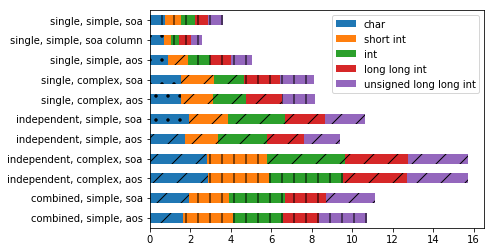

In [61]:
from math import log
ap = ['combined', 'independent', 'single']
complexity = ['complex', 'simple']
types = ['char', 'short int', 'int', 'long long int', 'unsigned long long int']
orientations = ['aos', 'soa']
column = ['column', 'nocolumn']

idxs = list()

for _ap in ap:
    for _cp in complexity:
        for o in orientations:
            for _col in column:
                if _ap == 'combined' and _cp == 'complex':
                    continue
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                idxs.append(idx_str)

dfs = pd.DataFrame(columns=types, index=idxs)                

for _ap in ap:
    for _cp in complexity:
        for _col in column:
            if _ap == 'combined' and _cp == 'complex':
                continue
            must_haves = {
                'container_size': 65536,
                'access_pattern': _ap,
                'complexity': _cp,
                'column': _col,
                'iterations': 32768
            }
                
            filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
            allowed_types = D.make_tuple_types(types, [4])
            filter_dicts = D.constrain_types(filter_dicts, allowed_types)
            selection = D.multi_filter_df(filter_dicts, df)
            selection = D.add_type_bases(selection)
            selection['timing'] = selection['timing'].apply(lambda l: np.mean(l) * 1e9)
            selection['timing'] /= selection['container_size']
            selection['timing'] /= selection['iterations']
            for o in ['aos', 'soa']:
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                o_sel = selection[selection['orientation'] == o]
                d = {'lbl': ''}
                for t in types:
                    d[t] = log(o_sel[o_sel['type_base'] == t].iloc[0]['timing'])
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                d['lbl'] = idx_str
                dfs.loc[idx_str] = d
                
ax = dfs.plot.barh(stacked=True)
bars = ax.patches
bar_types = ['soa', 'soac', 'aos']
for i in range(0, 5):
    bar_types.append('soa')
    bar_types.append('aos')
hatches = []
for b_type in bar_types:
    if b_type == 'soa':
        hatches += (['/'] * 5)
    elif b_type == 'aos':
        hatches += (['|'] * 5)
    else:
        hatches += (['.'] * 5)

print(hatches)
hatch_idx = 0
for bar in bars:
    bar.set_hatch(hatches[hatch_idx])
    hatch_idx += 1
fig = ax.get_figure()
fig.savefig('log_scale', bbox_inches='tight')
df2

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
40,23.9,9.082,9.799,22.944,19.359,858.97,116.29,SC
34,23.9,5.497,10.038,23.661,20.554,688.75,109.72,ND
48,23.8,8.092,6.664,23.086,20.706,992.61,152.56,WV
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
17,21.4,4.066,4.922,16.692,16.264,872.51,137.13,KY
26,21.4,8.346,9.416,17.976,18.190,816.21,85.15,MT
18,20.5,7.175,6.765,14.965,20.090,1281.55,194.78,LA
36,19.9,6.368,5.771,18.308,18.706,881.51,178.86,OK
42,19.5,4.095,5.655,15.990,15.795,767.91,155.57,TN
43,19.4,7.760,7.372,17.654,16.878,1004.75,156.83,TX


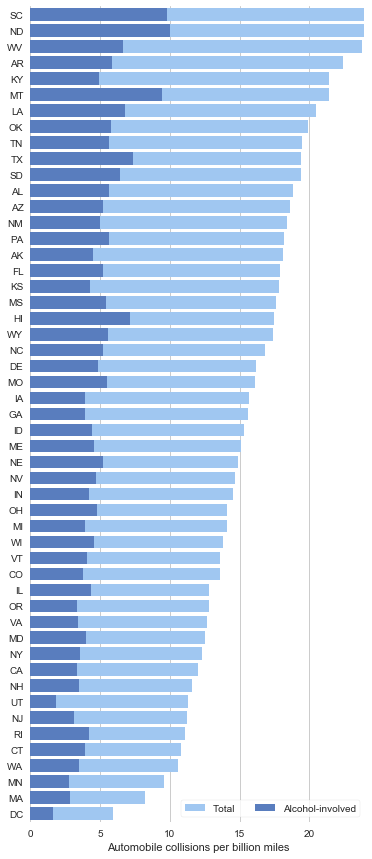

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Load the example car crash dataset
crashes = sns.load_dataset("car_crashes").sort_values("total", ascending=False)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="abbrev", data=crashes,
            label="Total", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)

crashes

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
from math import log
ap = ['combined', 'independent', 'single']
complexity = ['complex', 'simple']
types = ['char', 'short int', 'int', 'long long int', 'unsigned long long int']
orientations = ['aos', 'soa']
column = ['column', 'nocolumn']

idxs = list()

for _ap in ap:
    for _cp in complexity:
        for o in orientations:
            for _col in column:
                if _ap == 'combined' and _cp == 'complex':
                    continue
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                idxs.append(idx_str)
columns = types
columns.append('lbl')
dfs = pd.DataFrame(columns=columns, index=idxs)                

for _ap in ap:
    for _cp in complexity:
        for _col in column:
            if _ap == 'combined' and _cp == 'complex':
                continue
            must_haves = {
                'container_size': 65536,
                'access_pattern': _ap,
                'complexity': _cp,
                'column': _col,
                'iterations': 32768
            }
                
            filter_dicts = D.experiment_filter_dicts(unique, must_haves, let_vary)
            allowed_types = D.make_tuple_types(types, [4])
            filter_dicts = D.constrain_types(filter_dicts, allowed_types)
            selection = D.multi_filter_df(filter_dicts, df)
            selection = D.add_type_bases(selection)
            selection['timing'] = selection['timing'].apply(lambda l: np.mean(l) * 1e9)
            selection['timing'] /= selection['container_size']
            selection['timing'] /= selection['iterations']
            for o in ['aos', 'soa']:
                if _col == 'column' and not (_ap == 'single' and _cp == 'simple' and o == 'soa'):
                    continue
                o_sel = selection[selection['orientation'] == o]
                d = {'lbl': ''}
                for t in types:
                    d[t] = log(o_sel[o_sel['type_base'] == t].iloc[0]['timing'])
                orient = o
                if _col == 'column':
                    orient += ' column'
                idx_str = '{i}, {j}, {k}'.format(i=_ap,j=_cp,k=orient)
                d['lbl'] = idx_str
                dfs.loc[idx_str] = d

                
for _type in types:
    sns.barplot(x=_type, y="lbl", data=dfs, label=_type, color="b")
sns.despine(left=True, bottom=True)
dfs

IndexError: single positional indexer is out-of-bounds